# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
- Logan Lary
- Mark Tran
- Sabrina Valerjev

## Part 1: 
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.

## Project Motivation 
The motivation for this project comes from our passion for movies and our curiosity about the factors that make them successful. As avid movie watchers, we are keen to explore the metadata behind films to uncover insights that intrigue us and hopefully resonate with others as well. This project aims to investigate the elements influencing both a movie's financial and critical success, such as cast, director, genre, release timing, studio, plot, and awards. By analyzing how these factors interact over time, we plan to create a predictive model that can estimate box office performance, forecast award nominations, and predict audience ratings. The key questions we seek to answer include: What factors have the most significant impact on a movie’s success? How do these factors evolve, and how can they be used to predict future outcomes? This research will uncover trends in popular genres and success patterns, offering valuable insights for investors and helping to guide movie recommendations based on predicted success.

## Summary of the Data Processing Pipeline
1. Web scrape from Box Office Mojo
2. Create list of movies per year
3. Use OMDb to access movie metadata each movie in the list
4. Merge all the data into a single dataframe
5. Clean the data

The first step in our data processing pipeline was to scrape all box office mojo data. For this step, we referrenced and modified exisiting code written and published by Justin Mitchel on GitHub. This code provided the base for understanding the intricate setup of Box Office Mojo. The code was modified to work on any valid inputted year. The data from Box Office Mojo provided us a list with all of the movies from each year. We isolated this list of movie titles and fed them into OMDb to collect the metadata on each film. The last step in data collection was to merge the data on the shared "Title" attribute. This ensures that the financial information and movie information both reference the correct film. One difficulty in this data collection process was the limited amount of calls we could make to OMDb per day. To get around this limitation, we only requested data for certain years each day, and merged the resulting dataframes to get the entire collection of data. The data cleaning of this dataframe was simple. We decided to simplify the financial data by removing the commas and dollars sign from the numbers and converting the sums from dollars to millions of dollars to make future math calculations more simple. We also dropped columns that we determined to be not needed.

## Part 2: 
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [2]:
# adding relevant imports
import requests
from requests_html import HTML
import json
import pathlib
import pandas as pd
import requests
from requests_html import HTML
from dataclasses import dataclass

In [3]:
# Source 1: Box Office Mojo
@dataclass
class ScrapeBoxOffice:
    base_endpoint:str = "https://www.boxofficemojo.com/year/world/"
    year:int = None
    save_raw:bool = False
    save:bool = False
    output_dir: str = "."
    table_selector: str = '.imdb-scroll-table'
    table_data = []
    table_header_names = []
    df = pd.DataFrame()
    
    @property
    def name(self):
        return self.year if isinstance(self.year, int) else 'world'
    
    def get_endpoint(self):
        endpoint = self.base_endpoint
        if isinstance(self.year, int):
            endpoint = f"{endpoint}{self.year}/"
        return endpoint
    
    def get_output_dir(self):
        return pathlib.Path(self.output_dir)
    
    def extract_html_str(self, endpoint=None):
        url = endpoint if endpoint is not None else self.get_endpoint()
        r = requests.get(url, stream=True)
        html_text = None
        status = r.status_code
        if r.status_code == 200:
            html_text = r.text
            if self.save_raw:
                output_fname = f"{self.name}.html"
                raw_output_dir = self.get_output_dir() / 'html'
                raw_output_dir.mkdir(exist_ok=True, parents=True)
                output_fname = raw_output_dir / output_fname
                with open(f"{output_fname}", 'w') as f:
                    f.write(html_text)
            return html_text, status
        return html_text, status
    
    def parse_html(self, html_str=''):
        r_html = HTML(html=html_str)
        r_table = r_html.find(self.table_selector)
        if len(r_table) == 0:
            return None
        table_data = []
        header_names = []
        parsed_table = r_table[0]
        rows = parsed_table.find("tr")
        header_row = rows[0]
        header_cols = header_row.find('th')
        header_names = [x.text for x in header_cols]
        for row in rows[1:]:
            cols = row.find("td")
            row_data = []
            row_dict_data = {}
            for i, col in enumerate(cols):
                header_name = header_names[i]
                row_data.append(col.text)
            table_data.append(row_data)
        self.table_data = table_data
        self.table_header_names = header_names
        return self.table_data, self.table_header_names
    
    def to_df(self, data=[], columns=[]):
        return pd.DataFrame(data, columns=columns)
    
    def run(self, save=False):
        save = self.save if save is False else save
        endpoint = self.get_endpoint()
        html_str, status = self.extract_html_str(endpoint=endpoint)
        if status not in range(200, 299):
            raise Exception(f"Extraction failed, endpoint status {status} at {endpoint}")
        data, headers = self.parse_html(html_str if html_str is not None else '')
        df = self.to_df(data=data, columns=headers)
        self.df = df
        if save:
            filepath = self.get_output_dir() / f'{self.name}.csv'
            df.to_csv(filepath, index=False)
        return self.df

In [4]:
# Source 2: OMDb
API_KEY = "64cf5c15"
URL = "http://www.omdbapi.com/?t="

def get_movie_data(url, movie):
    ''' Takes in the name of a movie and returns associated data on the movie.'''
    movie_link = process_movie_name(movie)
    complete_url = url + movie_link + "&apikey=" + API_KEY
    response = requests.get(complete_url) 
    return response.json()

def process_movie_name(movie):
    ''' Takes in the name of a movie and modifies it so that it can be used in API call.'''
    words = movie.split()
    return '+'.join(words)

# get the list of all movies in a year
# get data on all those movies
# save to a json
def get_year_movie_data(movie_titles, url, year):
    empty_data = {}
    data_list = []
    for movie in movie_titles:
        response = get_movie_data(url, movie)
        data_list.append(response)
    with open("MovieData" + year + ".json", 'w') as json_file:
        json.dump(data_list, json_file, indent=4) 



In [ ]:
year = 2010
dataframe_1 = pd.DataFrame()
# we can only download ~ 3 years of data at one time
# only run each while loop once, to download all the data and prevent overloading the api
# this while loop scrapes the box office data into a csv, and save movie metadata as a json
while year < 2013:
    scrapper = ScrapeBoxOffice(year=year, save=True, save_raw=True, output_dir='data')
    df_box = scrapper.run()
    movies_year = df_box["Release Group"].tolist()
    get_year_movie_data(movies_year, "http://www.omdbapi.com/?t=", str(year))
    year += 1
 

In [ ]:
year = 2013
dataframe_1 = pd.DataFrame()
while year < 2017:
    scrapper = ScrapeBoxOffice(year=year, save=True, save_raw=True, output_dir='data')
    df_box = scrapper.run()
    movies_year = df_box["Release Group"].tolist()
    get_year_movie_data(movies_year, "http://www.omdbapi.com/?t=", str(year))
    year += 1

In [15]:
year = 2017
dataframe_1 = pd.DataFrame()
while year < 2021:
    scrapper = ScrapeBoxOffice(year=year, save=True, save_raw=True, output_dir='data')
    df_box = scrapper.run()
    movies_year = df_box["Release Group"].tolist()
    get_year_movie_data(movies_year, "http://www.omdbapi.com/?t=", str(year))
    year += 1

In [ ]:
year = 2021
dataframe_1 = pd.DataFrame()
while year < 2024:
    scrapper = ScrapeBoxOffice(year=year, save=True, save_raw=True, output_dir='data')
    df_box = scrapper.run()
    movies_year = df_box["Release Group"].tolist()
    get_year_movie_data(movies_year, "http://www.omdbapi.com/?t=", str(year))
    year += 1

In [14]:
# creating dataframe once all data has already been downloaded
year = 2010
master_data = pd.DataFrame()

while year < 2024:
    # Read Box Office Mojo data for the year (CSV)
    box_file = f"data/{year}.csv"
    df_box = pd.read_csv(box_file)
    
    # Read OMDb data for the year (JSON converted to DataFrame)
    movie_json_file = "MovieData" + str(year) + ".json"
    df_movie = pd.read_json(movie_json_file)
    
    # Rename Box Office column to match OMDb ('Release Group' -> 'Title')
    df_box_renamed = df_box.rename(columns={"Release Group": "Title"})
    
    # Merge OMDb and Box Office Mojo data on Title using an inner join
    merged_df = pd.merge(df_movie, df_box_renamed, on="Title", how="inner")
    merged_df["Year"] = year  # add the year as a column
    master_data = pd.concat([master_data, merged_df], ignore_index=True)
    
    year += 1

In [ ]:
# gets movie data from TMDb API
def get_tmdb_movies_by_year(api_key, year, min_count=30):
    """ retrieves movies from TMDb API for a given release year,
        collecting details such as title, release year, genres, rating, runtime,
        director, writer, and top actors
        tracks seen movie IDs so that it avoids collecting duplicates

    Args:
        api_key (str): your TMDb API key
        year (int): release year to filter movies by
        min_count (int): minimum number of movies to collect (defaults to 30)

    Returns:
        df: a dataframe sorted by rating in descending order
    """
    movie_list = []
    processed_ids = set()  # to track movie IDs already processed
    page = 1
    url = "https://api.themoviedb.org/3/discover/movie"
    
    while True:
        params = {
            "api_key": api_key,
            "sort_by": "popularity.desc",
            "page": page,
            "with_original_language": "en",
            "primary_release_year": year
        }
        response = requests.get(url, params=params)
        data = response.json()
        
        if page == 1:
            total_pages = data.get("total_pages", 1)
        
        movies = data.get("results", [])
        if not movies:
            break
        
        for movie in movies:
            movie_id = movie.get("id")
            # skips if movie has already been processed
            if movie_id in processed_ids:
                continue
            processed_ids.add(movie_id)
            
            # gets detailed movie info
            movie_details_url = f"https://api.themoviedb.org/3/movie/{movie_id}"
            details = requests.get(movie_details_url, params={"api_key": api_key}).json()
            
            # gets credits for director, writer, and top actors
            credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
            credits = requests.get(credits_url, params={"api_key": api_key}).json()
            director = ""
            writer = ""
            actors = []
            
            for member in credits.get("crew", []):
                if member.get("job") == "Director":
                    director = member.get("name")
                    break
            
            for member in credits.get("crew", []):
                if member.get("job") == "Writer":
                    writer = member.get("name")
                    break
                    
            for member in credits.get("cast", []):
                # gets top three actors
                if member.get("order") < 3:
                    actors.append(member.get("name"))
            
            # extracts release year, genres, language, plot, and country
            release_date = details.get("release_date", "")
            release_year = release_date.split("-")[0] if release_date else ""
            genres = ", ".join([genre["name"] for genre in details.get("genres", [])])
            language = details.get("original_language", "")
            plot = details.get("overview", "")
            country = details.get("origin_country", "")
            country = ", ".join(country) if isinstance(country, list) else country
            actors_str = ", ".join(actors)
            
            movie_data = {
                "Title": details.get("title"),
                "Year": release_year,
                "Genres": genres,
                "Rating": details.get("vote_average"),
                "Runtime": details.get("runtime"),
                "Director": director,
                "Writer": writer,
                "Actors": actors_str,
                "Plot": plot,
                "Language": language,
                "Country": country
            }
            movie_list.append(movie_data)
        
        if len(movie_list) >= min_count or page >= total_pages:
            break
        
        page += 1
    
    df = pd.DataFrame(movie_list)
    df = df.sort_values("Rating", ascending=False).reset_index(drop=True)
    return df

In [ ]:
# reads the TMDb CSV files per year range into a single dataframe
# merges with the OMDb and Box Office Mojo dataframe
tmdb_list = []
for yr in range(2010, 2024):
    tmdb_file = f"tmdb_{yr}_data.csv"
    df_tmdb = pd.read_csv(tmdb_file)
    # ensures year column is string to match other dataframe
    df_tmdb["Year"] = df_tmdb["Year"].astype(str)
    tmdb_list.append(df_tmdb)
tmdb_all = pd.concat(tmdb_list, ignore_index=True)

# drops columns from TMDb that are already collected by OMDb/Box Office
columns_to_drop = ["Genres", "Runtime", "Director", "Writer", "Plot", "Actors", "Language", "Country"]
tmdb_clean = tmdb_all.drop(columns=columns_to_drop, errors="ignore")

# ensures year in previous dataframe is string for merging
master_data["Year"] = master_data["Year"].astype(str)

# merge on Title and Year to match movie information
# uses left join to preserve all the dataframe rows
final_df = pd.merge(master_data, tmdb_clean, on=["Title", "Year"], how="left", suffixes=("", "_tmdb"))

In [42]:
final_df.to_csv("final_merged_movie_data.csv", index=False)
print("Final columns:", final_df.columns)
final_df.head()

Final columns: Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster',
       'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type',
       'DVD', 'BoxOffice', 'Production', 'Website', 'Response', 'Error',
       'totalSeasons', 'Rank', 'Worldwide', 'Domestic', '%', 'Foreign', '%.1',
       'Rating'],
      dtype='object')


,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Response,Error,totalSeasons,Rank,Worldwide,Domestic,%,Foreign,%.1,Rating
0,Toy Story 3,2010,G,18 Jun 2010,103 min,"Animation, Adventure, Comedy",Lee Unkrich,"John Lasseter, Andrew Stanton, Lee Unkrich","Tom Hanks, Tim Allen, Joan Cusack",The toys are mistakenly delivered to a day-car...,...,True,NaN,NaN,1,"$1,066,969,703","$415,004,880",38.9%,"$651,964,823",61.1%,7.799
1,Alice in Wonderland,2010,PG,05 Mar 2010,108 min,"Adventure, Family, Fantasy",Tim Burton,"Linda Woolverton, Lewis Carroll","Mia Wasikowska, Johnny Depp, Helena Bonham Carter",Nineteen-year-old Alice returns to the magical...,...,True,NaN,NaN,2,"$1,025,467,110","$334,191,110",32.6%,"$691,276,000",67.4%,6.638
2,Harry Potter and the Deathly Hallows: Part 1,2010,PG-13,19 Nov 2010,146 min,"Adventure, Family, Fantasy",David Yates,"Steve Kloves, J.K. Rowling","Daniel Radcliffe, Emma Watson, Rupert Grint",Harry Potter is tasked with the dangerous and ...,...,True,NaN,NaN,3,"$960,283,305","$295,983,305",30.8%,"$664,300,000",69.2%,7.700
3,Inception,2010,PG-13,16 Jul 2010,148 min,"Action, Adventure, Sci-Fi",Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,...,True,NaN,NaN,4,"$828,258,695","$292,576,195",35.3%,"$535,682,500",64.7%,8.369
4,Shrek Forever After,2010,PG,21 May 2010,93 min,"Animation, Adventure, Comedy",Mike Mitchell,"Josh Klausner, Darren Lemke, William Steig","Mike Myers, Cameron Diaz, Eddie Murphy",Rumpelstiltskin tricks a mid-life crisis burde...,...,True,NaN,NaN,5,"$752,600,867","$238,736,787",31.7%,"$513,864,080",68.3%,6.380


In [46]:
# cleaning the data
def clean_box_office(df):
    '''Cleans box office sales by removing dollar signs and commas, and drops rows where Domestic value is "-".'''
    # Clean Worldwide column
    df = df[df["Domestic"] != "-"]
    df = df.dropna(subset = ["Worldwide", "Domestic", "Foreign"])
    df["Worldwide"] = (
        df["Worldwide"]
        .astype(str)  
        .str.replace("$", "", regex=False)  
        .str.replace(",", "", regex=False)  
        .astype(int)
    )
    # Clean Domestic column
    df["Domestic"] = (
        df["Domestic"]
        .astype(str)  
        .str.replace("$", "", regex=False) 
        .str.replace(",", "", regex=False)  
    
    )
    # Clean Foreign column
    df["Foreign"] = (
        df["Foreign"]
        .astype(str)  
        .str.replace("$", "", regex=False)  
        .str.replace(",", "", regex=False)  
    )
    # Creating new columns because the raw numbers are too large to process
    df["Worldwide_millions"] = pd.to_numeric(df["Worldwide"]) / 1000000
    df["Domestic_millions"] = pd.to_numeric(df["Domestic"]) / 1000000
    df["Foreign_millions"] = pd.to_numeric(df["Foreign"], errors="coerce") / 1000000
    return df

#dataframe = dataframe.drop(["Type", "Poster", "DVD", "totalSeasons", "Error", "Response", "Website", "Rank", "Production", "Ratings", "imdbRating", "imdbVotes"], axis=1)
#cleaned_df = clean_box_office(dataframe)

In [47]:
cleaned_df = clean_box_office(final_df)
cleaned_df[["Worldwide", "Domestic", "Foreign", 
            "Worldwide_millions", "Domestic_millions", "Foreign_millions"]].head()

,Worldwide,Domestic,Foreign,Worldwide_millions,Domestic_millions,Foreign_millions
0,1066969703,415004880,651964823,1066.969703,415.004880,651.964823
1,1025467110,334191110,691276000,1025.467110,334.191110,691.276000
2,960283305,295983305,664300000,960.283305,295.983305,664.300000
3,828258695,292576195,535682500,828.258695,292.576195,535.682500
4,752600867,238736787,513864080,752.600867,238.736787,513.864080


## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

The visualizations that we made for this part are:
(1) Genre analysis histogram: for all movies in the time period, how many are there of each genre? Which genre is the most popular?
(2) Time series analysis on box office revenue: how has total box office revenue fluctuated over the time period?

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

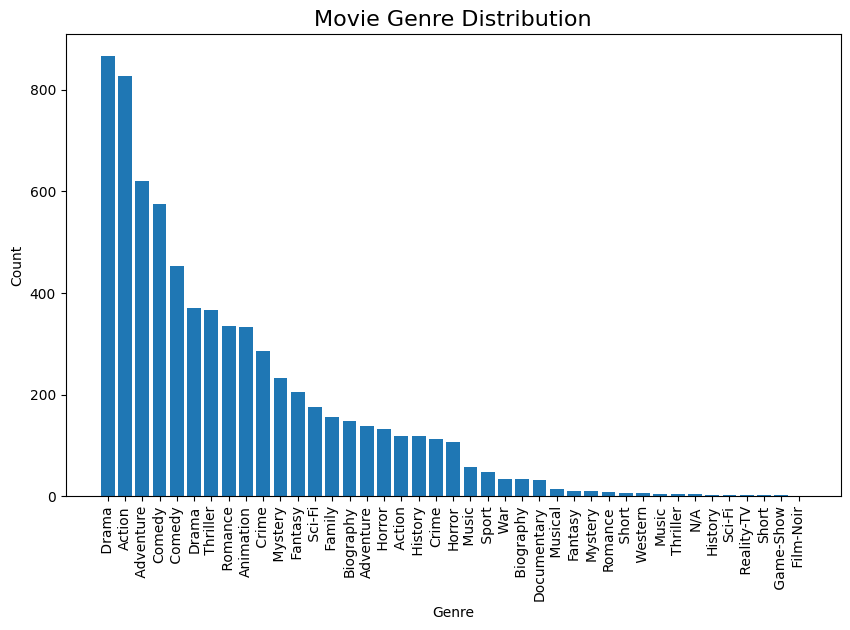

In [33]:
# Viz 1: Histogram

# Split the genres into separate entries and count them
genre_series = final_df['Genre'].str.split(',', expand=True).stack().reset_index(drop=True)


genre_counts = genre_series.value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.title("Movie Genre Distribution", fontsize=16)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90) 
plt.show()


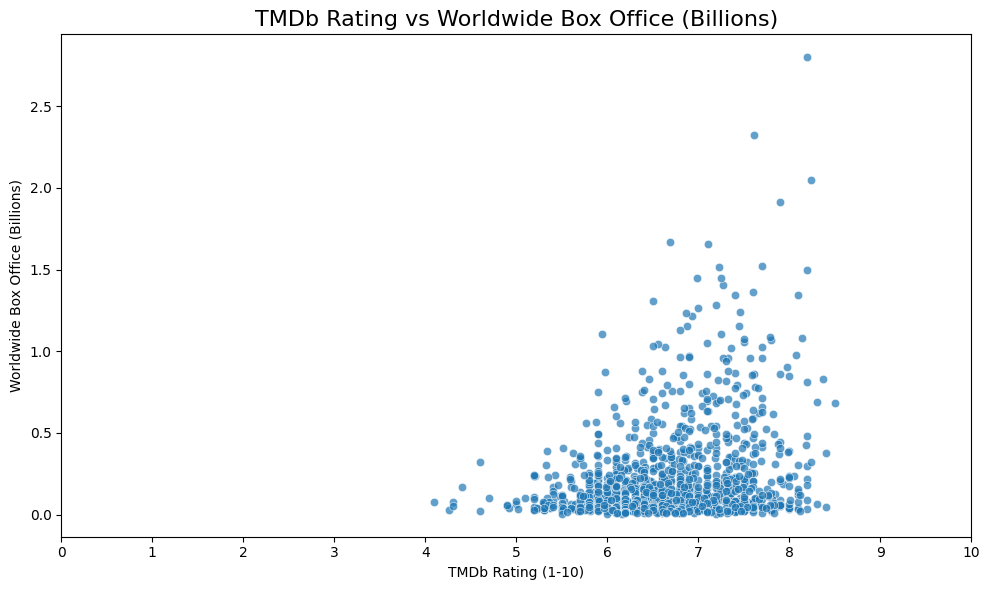

In [ ]:
# takes cleaned dataframe and converts worldwide to billions
cleaned_df["Worldwide_Billions"] = cleaned_df["Worldwide"] / 1e9
# takes cleaned dataframe and converts ratings to numeric
cleaned_df["Rating"] = pd.to_numeric(cleaned_df["Rating"], errors="coerce")

# uses data from cleaned final dataframe
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cleaned_df,
    x="Rating",             # numeric rating
    y="Worldwide_Billions", # worldwide in billions
    alpha=0.7
)

# building plot
plt.title("TMDb Rating vs Worldwide Box Office (Billions)", fontsize=16)
plt.xlabel("TMDb Rating (1-10)")
plt.ylabel("Worldwide Box Office (Billions)")
plt.xlim(0, 10)
plt.xticks(range(0, 11))
plt.tight_layout()
plt.show()

